In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Short-nominal rate: Euribor 3-month

In [26]:
euribor3Month = pd.read_csv('ECB_euribor_3_month.csv')
euribor3Month.rename(columns={'Euribor 3-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA)': 'euribor_3_month'}, inplace=True)
euribor3Month['euribor_3_month'] = euribor3Month['euribor_3_month'].astype(float)
euribor3Month['DATE'] = pd.to_datetime(euribor3Month['DATE'])
euribor3Month['YEAR_MONTH'] = euribor3Month['DATE'].dt.to_period('M')
euribor3Month = euribor3Month[
    euribor3Month['YEAR_MONTH'].between('2003-03', '2021-01')
]
euribor3Month.set_index('YEAR_MONTH', inplace=True)
euribor3Month.index = euribor3Month.index.to_timestamp()
euribor3Month.drop(['TIME PERIOD', 'DATE'], axis=1, inplace=True)
euribor3Month['euribor_3_month'] = euribor3Month['euribor_3_month']/100
euribor3Month.head()

,euribor_3_month
YEAR_MONTH,
2003-03-01,0.025300
2003-04-01,0.025333
2003-05-01,0.024005
2003-06-01,0.021519
2003-07-01,0.021300


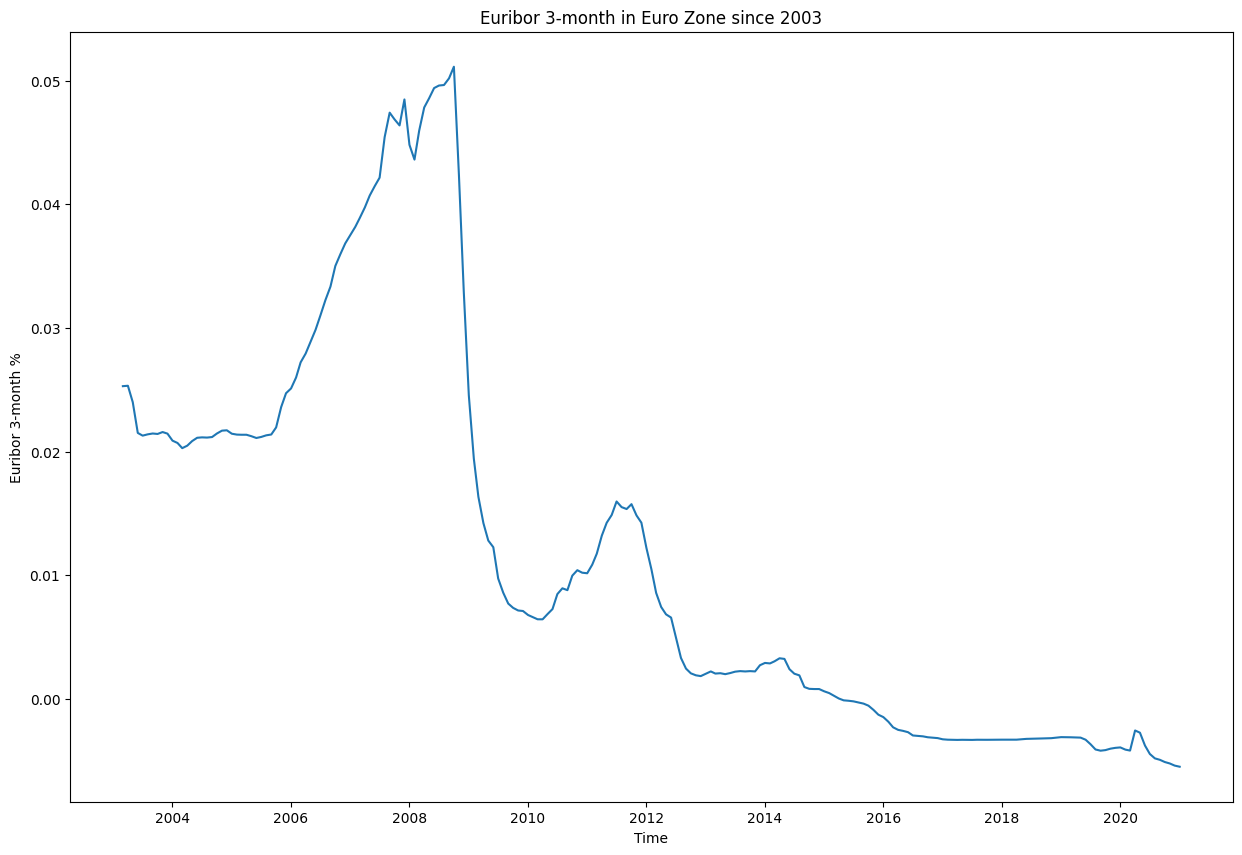

In [27]:
fig = plt.figure(figsize=(15,10))
plt.plot(euribor3Month.index, euribor3Month.euribor_3_month)
plt.xlabel('Time')
plt.ylabel('Euribor 3-month %')
plt.title('Euribor 3-month in Euro Zone since 2003')
plt.show()

In [28]:
euribor3Month.to_csv('euribor_3_month_processed.csv', index=True)

Long-nominal rate: Bund 10 years

In [29]:
bund10Years = pd.read_csv('Bund_10_years.csv')
bund10Years['time_period'] = pd.to_datetime(bund10Years['time_period'])
bund10Years = bund10Years[['time_period', 'obs_value']]
bund10Years.rename(columns={'obs_value': 'bund_10_years'}, inplace=True)
bund10Years['bund_10_years'] = bund10Years['bund_10_years'].astype(float)
bund10Years['YEAR_MONTH'] = bund10Years['time_period'].dt.to_period('M')
bund10Years = bund10Years[
    bund10Years['YEAR_MONTH'].between('2003-03', '2021-01')
]
bund10Years.set_index('YEAR_MONTH', inplace=True)
bund10Years.index = bund10Years.index.to_timestamp()
bund10Years.drop(['time_period'], axis=1, inplace=True)
bund10Years.sort_index(inplace=True)
bund10Years['bund_10_years'] = bund10Years['bund_10_years']/100
bund10Years.head()

,bund_10_years
YEAR_MONTH,
2003-03-01,0.040410
2003-04-01,0.041570
2003-05-01,0.038404
2003-06-01,0.036474
2003-07-01,0.040064


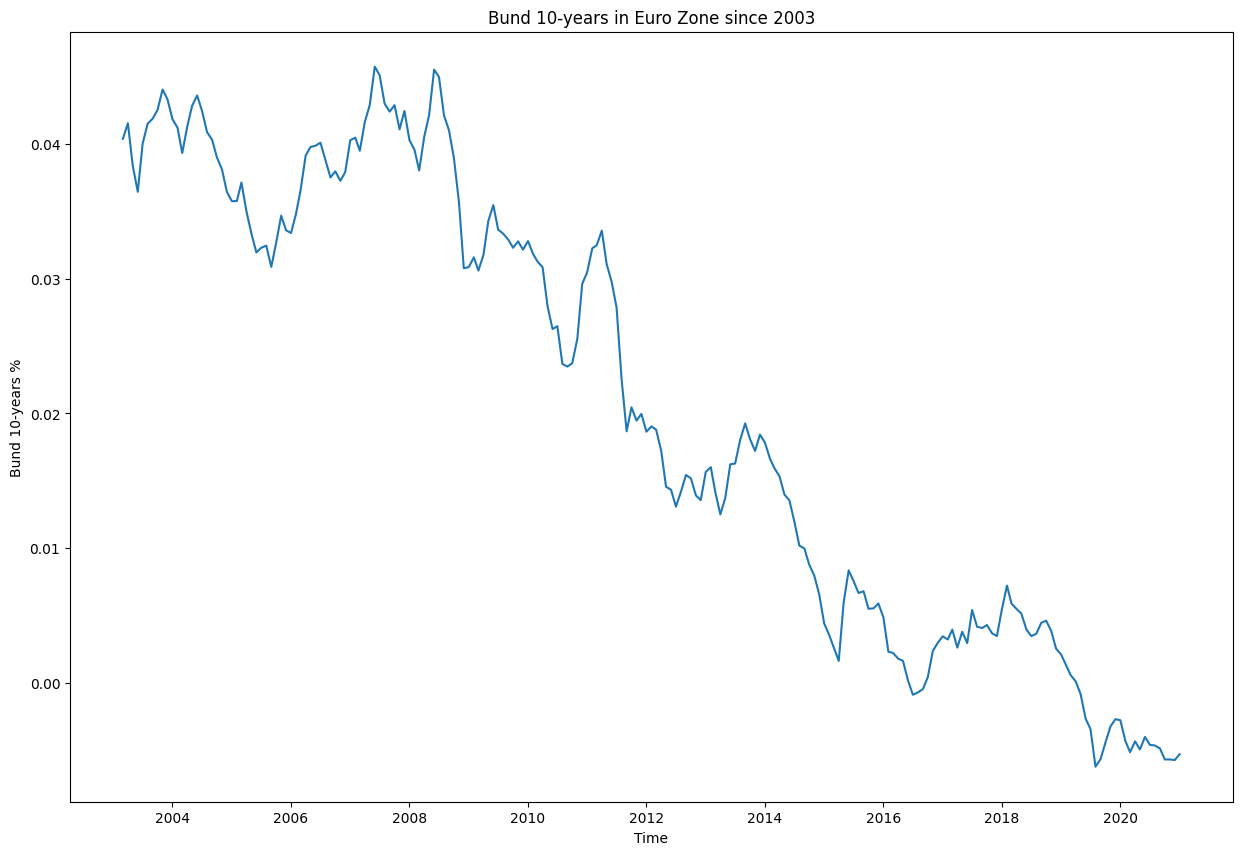

In [30]:
fig = plt.figure(figsize=(15,10))
plt.plot(bund10Years.index, bund10Years.bund_10_years)
plt.xlabel('Time')
plt.ylabel('Bund 10-years %')
plt.title('Bund 10-years in Euro Zone since 2003')
plt.show()

In [31]:
bund10Years.to_csv('bund_10_years_processed.csv', index=True)

Spread taux long/taux court

In [32]:
dates = bund10Years.index

spreadShortLongRates = pd.DataFrame(bund10Years.bund_10_years.values - euribor3Month.euribor_3_month.values, index=dates)
spreadShortLongRates.rename(columns={0: 'spread'}, inplace=True)
spreadShortLongRates.head()

,spread
YEAR_MONTH,
2003-03-01,0.015110
2003-04-01,0.016237
2003-05-01,0.014399
2003-06-01,0.014955
2003-07-01,0.018764


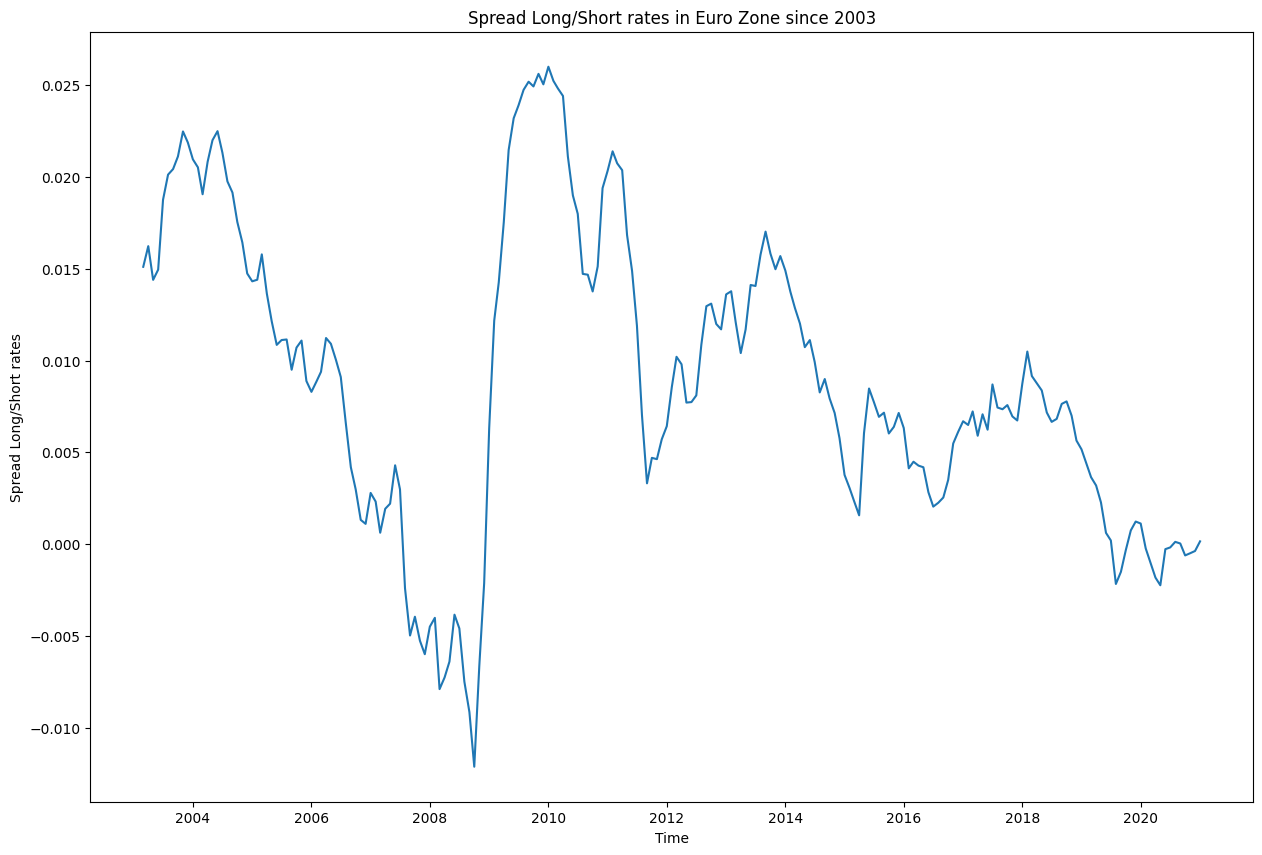

In [33]:
fig = plt.figure(figsize=(15,10))
plt.plot(spreadShortLongRates.index, spreadShortLongRates.spread)
plt.xlabel('Time')
plt.ylabel('Spread Long/Short rates')
plt.title('Spread Long/Short rates in Euro Zone since 2003')
plt.show()

In [34]:
spreadShortLongRates.to_csv('spread_short_long_rates_processed.csv', index=True)

2nd Modelling: Spread between long and short rates

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

class Vasicek:
    """
    Vasicek (Ornstein–Uhlenbeck) model for interest rates using the exact discretization
    as presented in the paper.
    
    The exact discretization is:
    
        r_{t+1} = μ (1 - exp(-a dt)) + exp(-a dt) r_t + σ √((1 - exp(-2a dt))/(2a)) ε_t
        
    where ε_t ~ N(0, 1).
    """
    def __init__(self):
        self.calibrated = False
        self.a = None       # Speed of mean reversion
        self.mu = None      # Long-term mean level
        self.sigma = None   # Volatility

    def calibrate_ols(self, r, dt):
        """
        Calibrate the Vasicek model parameters using Ordinary Least Squares (OLS).

        Parameters
        ----------
        r : array-like
            1D array of observed interest rates.
        dt : float
            Time step in years.

        Returns
        -------
        a_est : float
            Estimated speed of mean reversion.
        mu_est : float
            Estimated long-term mean level.
        sigma_est : float
            Estimated volatility.
        results : RegressionResults
            The full OLS regression results.
        """
        r = np.asarray(r).flatten()
        X = r[:-1]
        Y = r[1:]
        X_const = sm.add_constant(X)
        model = sm.OLS(Y, X_const)
        results = model.fit()
        
        alpha = results.params[0]
        beta = results.params[1]
        
        # Recover parameters using: beta = exp(-a dt) and alpha = μ (1 - exp(-a dt))
        a_est = -np.log(beta) / dt
        mu_est = alpha / (1 - beta)
        
        # Estimate sigma from the residual variance
        mse = results.mse_resid
        sigma_est = np.sqrt(mse * (2 * a_est / (1 - np.exp(-2 * a_est * dt))))
        
        self.a = a_est
        self.mu = mu_est
        self.sigma = sigma_est
        self.calibrated = True
        
        return a_est, mu_est, sigma_est, results

    def calibrate_mle(self, r, dt):
        """
        Calibrate the Vasicek model parameters using Maximum Likelihood Estimation (MLE).

        Parameters
        ----------
        r : array-like
            1D array of observed interest rates.
        dt : float
            Time step in years.

        Returns
        -------
        a_est : float
            Estimated speed of mean reversion.
        mu_est : float
            Estimated long-term mean level.
        sigma_est : float
            Estimated volatility.
        """
        r = np.asarray(r).flatten()
        n = len(r)
        S0 = np.sum(r[:-1]) / (n - 1)
        S1 = np.sum(r[1:]) / (n - 1)
        S00 = np.sum(r[:-1]**2) / (n - 1)
        S01 = np.sum(r[:-1] * r[1:]) / (n - 1)
        
        b_MLE = (S1 * S00 - S0 * S01) / (S0 * S1 - S0**2 - S01 + S00)
        a_est = 1 / dt * np.log((S0 - b_MLE) / (S1 - b_MLE))
        
        temp = 0
        for i in range(n - 1):
            m_i = r[i] * np.exp(-a_est * dt) + b_MLE * (1 - np.exp(-a_est * dt))
            temp += (r[i + 1] - m_i) ** 2
        sigma_est = np.sqrt((2 * a_est / (1 - np.exp(-2 * a_est * dt))) * (temp / (n - 1)))
        
        self.a = a_est
        self.mu = b_MLE
        self.sigma = sigma_est
        self.calibrated = True
        
        return a_est, b_MLE, sigma_est

    def simulate_exact(self, r0, T, num_steps, num_paths, a=None, mu=None, sigma=None):
        """
        Simulate the Vasicek model using the exact discretization.
        
        Parameters
        ----------
        r0 : float
            Initial interest rate.
        T : float
            Total time horizon (in years).
        num_steps : int
            Number of time steps.
        num_paths : int
            Number of simulation paths.
        a : float, optional
            Speed of mean reversion. If not provided, the calibrated value is used.
        mu : float, optional
            Long-term mean level. If not provided, the calibrated value is used.
        sigma : float, optional
            Volatility. If not provided, the calibrated value is used.
        
        Returns
        -------
        rates : ndarray
            Simulated interest rate paths of shape (num_steps+1, num_paths).
        """
        dt = T / num_steps
        
        if a is None or mu is None or sigma is None:
            if self.calibrated:
                a = self.a
                mu = self.mu
                sigma = self.sigma
            else:
                raise ValueError("Parameters not provided and the model is not calibrated.")
                
        rates = np.zeros((num_steps + 1, num_paths))
        rates[0, :] = r0
        
        exp_term = np.exp(-a * dt)
        drift = mu * (1 - exp_term)
        vol_factor = sigma * np.sqrt((1 - np.exp(-2 * a * dt)) / (2 * a))
        
        for t in range(1, num_steps + 1):
            dW = np.random.normal(0, 1, num_paths)
            rates[t, :] = drift + exp_term * rates[t - 1, :] + vol_factor * dW
            
        return rates
    
    def simulate_deterministic(self, r0, T, num_steps, num_paths, a=None, mu=None):
        """
        Simulate the deterministic (backtest) part by omitting the stochastic noise.
        
        r_{t+1} = μ (1 - exp(-a dt)) + exp(-a dt) * r_t.
        """
        dt = T / num_steps
        if a is None or mu is None:
            if self.calibrated:
                a, mu = self.a, self.mu
            else:
                raise ValueError("Parameters not provided and model not calibrated.")
        rates = np.zeros((num_steps+1, num_paths))
        rates[0, :] = r0
        exp_term = np.exp(-a * dt)
        drift = mu * (1 - exp_term)
        for t in range(1, num_steps+1):
            rates[t, :] = drift + exp_term * rates[t-1, :]
        return rates

    def plot_paths(self, time_axis, simulated_paths, average, upper_bound, lower_bound, deterministic=None, calibration_data=None):
        """
        Plot simulated paths along with average and bounds.
        
        Optionally, overlay the deterministic simulation and calibration data.
        """
        plt.figure(figsize=(10, 6))
        plt.title('Vasicek Model - Simulated Interest Rate Paths')
        plt.xlabel('Time (years)')
        plt.ylabel('Interest Rate')
        num_paths = simulated_paths.shape[1]
        for i in range(num_paths):
            plt.plot(time_axis, simulated_paths[:, i], lw=0.8, alpha=0.3, color='blue')
        plt.plot(time_axis, average, color='black', linestyle='--', lw=3, label='Average (Stochastic)')
        plt.plot(time_axis, upper_bound, color='grey', linestyle='--', lw=2, label='Upper Bound (2σ)')
        plt.plot(time_axis, lower_bound, color='grey', linestyle='--', lw=2, label='Lower Bound (2σ)')
        if deterministic is not None:
            plt.plot(time_axis, np.mean(deterministic, axis=1), color='green', linestyle='-', lw=3, label='Deterministic')
        if calibration_data is not None:
            calibration_data = np.asarray(calibration_data)
            if len(calibration_data) != len(time_axis):
                obs_time = np.linspace(time_axis[0], time_axis[-1], len(calibration_data))
                calibration_data = np.interp(time_axis, obs_time, calibration_data)
            plt.plot(time_axis, calibration_data, color='red', linestyle='-', lw=2, label='Real Data')
        plt.legend()
        plt.show()

Calibrating Long Term using MCO

In [36]:
bund_10_years_data = bund10Years.bund_10_years.values

dt = 1/12   
vasicek = Vasicek()
a_est, mu_est, sigma_est, ols_results_lt = vasicek.calibrate_ols(bund_10_years_data, dt)

print(f'Speed of mean reversion: {np.round(a_est, 2)} %')
print(f'Long term mean: {np.round(mu_est, 2)} %')
print(f'Sigma: {np.round(sigma_est, 2)} %')
print(f'R-Squared Adjusted: {np.round(ols_results_lt.rsquared_adj * 100, 2)} %')

Speed of mean reversion: 0.02 %
Long term mean: -0.1 %
Sigma: 0.01 %
R-Squared Adjusted: 99.18 %


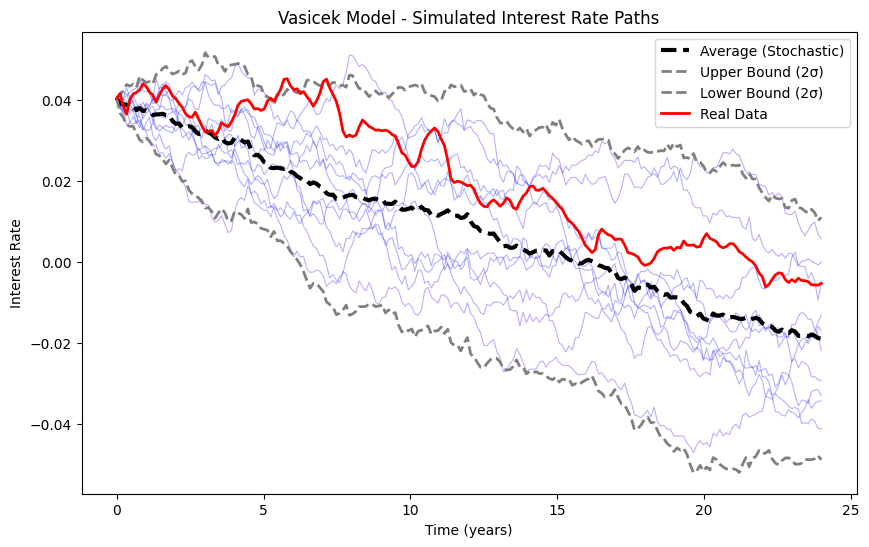

In [37]:
r0 = bund10Years.iloc[0]
T = 24
num_steps = len(bund_10_years_data-1) 
num_paths = 10
simulated = vasicek.simulate_exact(r0, T, num_steps, num_paths)

time_axis = np.linspace(0, T, num_steps+1)
avg_rates = np.mean(simulated, axis=1)
sigma_sim = np.std(simulated, axis=1)
upper_bound = avg_rates + 2 * sigma_sim
lower_bound = avg_rates - 2 * sigma_sim

vasicek.plot_paths(time_axis=time_axis, simulated_paths=simulated, average=avg_rates, upper_bound=upper_bound, lower_bound=lower_bound, deterministic=None, calibration_data=bund_10_years_data)

Calibrating Spread using MCO

In [38]:
spreadShortLongRates_data = spreadShortLongRates.spread.values

dt = 1/12 
vasicek = Vasicek()
a_est, mu_est, sigma_est, ols_results_spread = vasicek.calibrate_ols(spreadShortLongRates_data, dt)

print(f'Speed of mean reversion: {np.round(a_est, 2)} %')
print(f'Long term mean: {np.round(mu_est, 2)} %')
print(f'Sigma: {np.round(sigma_est, 2)} %')
print(f'R-Squared Adjusted: {np.round(ols_results_spread.rsquared_adj * 100, 2)} %')

Speed of mean reversion: 0.26 %
Long term mean: 0.01 %
Sigma: 0.01 %
R-Squared Adjusted: 95.43 %


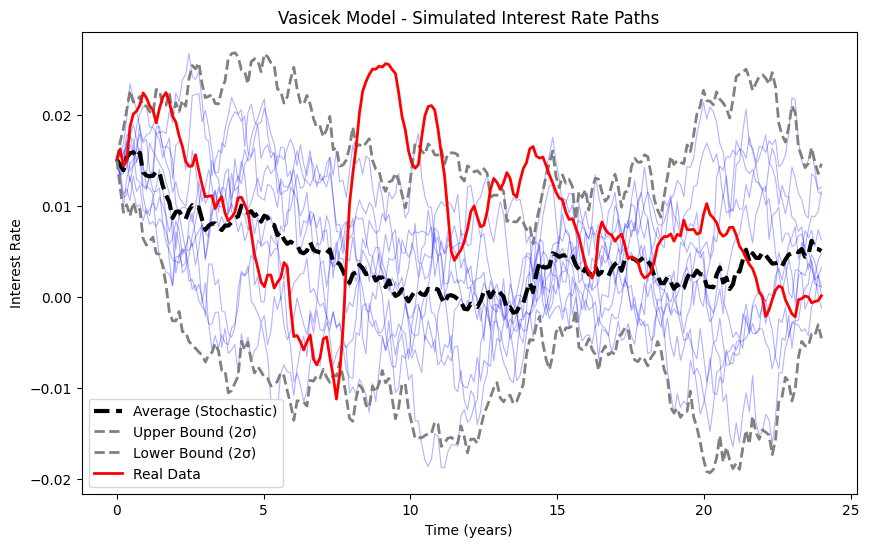

In [39]:
r0 = spreadShortLongRates.iloc[0]
T = 24
num_steps = len(spreadShortLongRates_data-1) 
num_paths = 10
simulated = vasicek.simulate_exact(r0, T, num_steps, num_paths)

time_axis = np.linspace(0, T, num_steps+1)
avg_rates = np.mean(simulated, axis=1)
sigma_sim = np.std(simulated, axis=1)
upper_bound = avg_rates + 2 * sigma_sim
lower_bound = avg_rates - 2 * sigma_sim

vasicek.plot_paths(time_axis=time_axis, simulated_paths=simulated, average=avg_rates, upper_bound=upper_bound, lower_bound=lower_bound, deterministic=None, calibration_data=spreadShortLongRates_data)

Normality of residuals test

Long Term Rates

In [40]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(ols_results_lt.resid)
shapiro_test

ShapiroResult(statistic=0.9862460467647307, pvalue=0.036276974078007035)

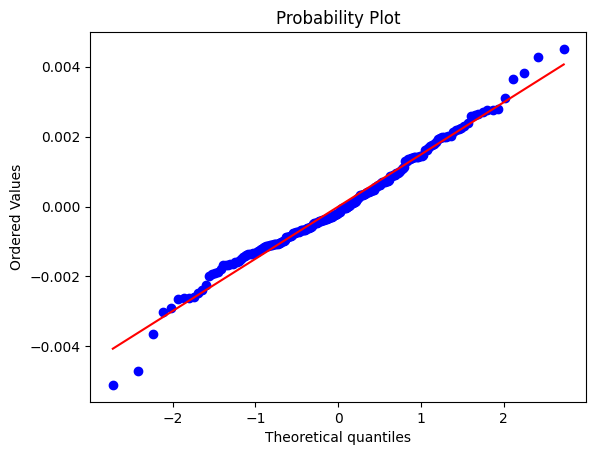

In [41]:
## QQ-Plot against normal distribution

stats.probplot(ols_results_lt.resid, dist='norm', plot=plt)
plt.show()

In [42]:
bund10Years = bund10Years.iloc[1:]
bund10Years['residuals'] = ols_results_lt.resid
bund10Years.to_csv("ols_model_residuals_long_term.csv", index=True)

Spread Model

In [43]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(ols_results_spread.resid)
shapiro_test

ShapiroResult(statistic=0.9549346797383234, pvalue=2.872448702788707e-06)

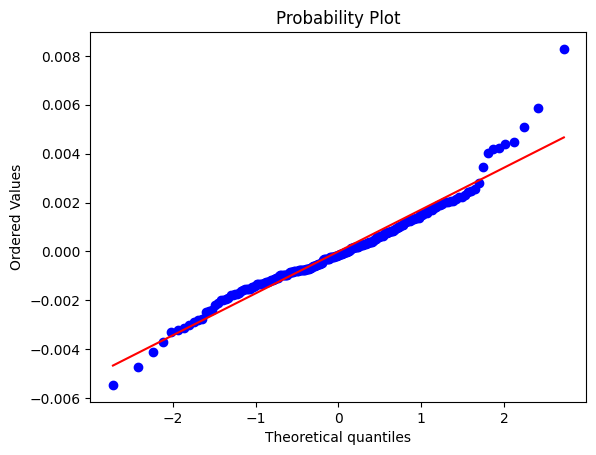

In [44]:
## QQ-Plot against normal distribution

stats.probplot(ols_results_spread.resid, dist='norm', plot=plt)
plt.show()

In [45]:
spreadShortLongRates = spreadShortLongRates.iloc[1:]
spreadShortLongRates['residuals'] = ols_results_spread.resid
spreadShortLongRates.to_csv("ols_model_residuals_spread.csv", index=True)

Backtesting with only the deterministic value

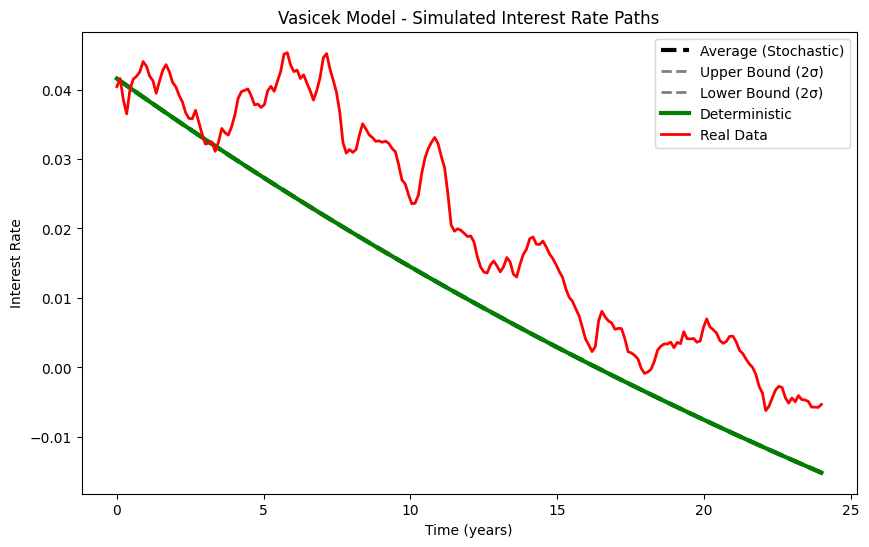

In [46]:
# Long Term Rates

dt = 1/12 
vasicek = Vasicek()
a_est, mu_est, sigma_est, ols_results = vasicek.calibrate_ols(bund_10_years_data, dt)

r0 = bund10Years.iloc[0]['bund_10_years']
T = 24
num_steps = len(bund_10_years_data-1) 
num_paths = 1
simulated_deterministic = vasicek.simulate_deterministic(r0, T, num_steps, num_paths)

time_axis = np.linspace(0, T, num_steps+1)
avg_rates = np.mean(simulated_deterministic, axis=1)
sigma_sim = np.std(simulated_deterministic, axis=1)
upper_bound = avg_rates + 2 * sigma_sim
lower_bound = avg_rates - 2 * sigma_sim

vasicek.plot_paths(time_axis=time_axis, simulated_paths=simulated_deterministic, average=avg_rates, upper_bound=upper_bound, lower_bound=lower_bound, deterministic=simulated_deterministic, calibration_data=bund_10_years_data)

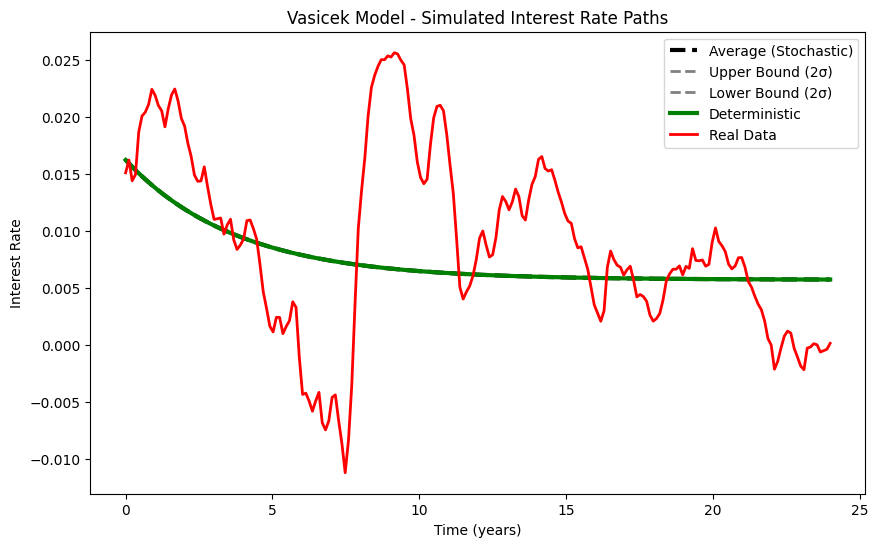

In [47]:
# Spread Model

dt = 1/12 
vasicek = Vasicek()
a_est, mu_est, sigma_est, ols_results = vasicek.calibrate_ols(spreadShortLongRates_data, dt)

r0 = spreadShortLongRates.iloc[0]['spread']
T = 24
num_steps = len(spreadShortLongRates_data-1) 
num_paths = 1
simulated_deterministic = vasicek.simulate_deterministic(r0, T, num_steps, num_paths)

time_axis = np.linspace(0, T, num_steps+1)
avg_rates = np.mean(simulated_deterministic, axis=1)
sigma_sim = np.std(simulated_deterministic, axis=1)
upper_bound = avg_rates + 2 * sigma_sim
lower_bound = avg_rates - 2 * sigma_sim

vasicek.plot_paths(time_axis=time_axis, simulated_paths=simulated_deterministic, average=avg_rates, upper_bound=upper_bound, lower_bound=lower_bound, deterministic=simulated_deterministic, calibration_data=spreadShortLongRates_data)